In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

Updated to use the new datasets (train / test splits)  
Remvoed the extra words to explain what was done 


# Imports

In [2]:
import pandas as pd
import torch
import random
import pickle

from utils.setup_graph import make_mapping, create_nodes
from utils.setup_embeddings import instantiate_users, custom_BLaIR_text_embedding_model
from utils.graph_model import BaseGNNRecommender, GNNSAGERecommender, BaseGNNRecommender_v2
from utils.graph_helpers import train_model, plot_loss, final_evaluation
from utils.recomendations import recommend_products, pretty_print_recomendations, paper_evaluation

/home/viknesh/.venv_ls/dl_proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [ ]:
user_features_numeric_agg = pd.read_parquet("data/cleaned_v2/user_features_numeric_agg.parquet")
user_features_numeric_pre_agg = pd.read_parquet("data/cleaned_v2/user_features_numeric_pre_agg.parquet")
user_features_string_agg = pd.read_parquet("data/cleaned_v2/user_features_string_agg.parquet")
user_features_string_pre_agg = pd.read_parquet("data/cleaned_v2/user_features_string_pre_agg.parquet")
product_features_numeric = pd.read_parquet("data/cleaned_v2/product_features_numeric.parquet")
product_features_string = pd.read_parquet("data/cleaned_v2/product_features_string.parquet")
train_edges = pd.read_parquet("data/cleaned_v2/train_edges.parquet")
test_edges = pd.read_parquet("data/cleaned_v2/test_edges.parquet")
val_edges = pd.read_parquet("data/cleaned_v2/val_edges.parquet")

user_id_to_idx = pickle.load(open("data/cleaned_v2/user_id_to_idx.pkl", "rb"))
prod_id_to_idx = pickle.load(open("data/cleaned_v2/prod_id_to_idx.pkl", "rb"))

In [ ]:
# # just for fun make it even smaller 
# from datasets import load_dataset
# import numpy as np

# reviews_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
# product_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full", trust_remote_code=True)

# review_df = reviews_dataset['full'].to_pandas()
# product_df = product_dataset.to_pandas()

# agg_user_df = pd.read_csv("data/cleaned/user_metadata.csv")
# new_product_df = pd.read_csv("data/cleaned/product_metadata.csv")

# # additional remove to only take rows with more than 1 review
# review_df = review_df.drop_duplicates(subset = ["user_id", "parent_asin"])
# ctx = review_df.groupby("user_id").parent_asin.count().reset_index()
# wanted_users = ctx[ctx.parent_asin > 1].user_id
# wanted_prods = review_df[review_df.user_id.isin(wanted_users)].parent_asin
# useful_parent_asin = (set(review_df.parent_asin)
#                       .intersection(set(product_df.parent_asin))
#                       .intersection(set(new_product_df.parent_asin))
#                       .intersection(set(wanted_prods))
# )
# review_df = review_df[review_df.parent_asin.isin(useful_parent_asin)]
# product_df = product_df[product_df.parent_asin.isin(useful_parent_asin)]
# new_product_df = new_product_df[new_product_df.parent_asin.isin(useful_parent_asin)]
# useful_user_id = (set(review_df.user_id).intersection(set(agg_user_df.user_id)).intersection(set(wanted_users)))
# review_df = review_df[review_df.user_id.isin(useful_user_id)]
# agg_user_df = agg_user_df[agg_user_df.user_id.isin(useful_user_id)]
# user_features_numeric_agg = agg_user_df.drop("reviews", axis = 1)
# user_features_numeric_pre_agg = review_df[["user_id", "parent_asin", "rating", "helpful_vote", "verified_purchase"]]
# user_features_string_agg = agg_user_df[["user_id", "reviews"]]
# user_features_string_pre_agg = review_df[["user_id", "parent_asin", "title", "text", ]]
# product_features_numeric = product_df[["parent_asin", "main_category", "average_rating", "rating_number", "price"]]
# product_features_string = pd.merge(product_df[["parent_asin", "title", "features", "description", "store", "details"]], new_product_df)
# edge_df = review_df[["user_id", "parent_asin", "rating", "timestamp"]].copy()
# user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(edge_df.user_id.unique())}
# prod_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(edge_df.parent_asin.unique())}
# edge_df["user_idx"] = edge_df.user_id.apply(lambda x: user_id_to_idx[x])
# edge_df["prod_idx"] = edge_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
# train_mark = np.quantile(edge_df.timestamp, 0.7)
# test_mark = np.quantile(edge_df.timestamp, 0.85)
# train_edges = edge_df[edge_df.timestamp <= train_mark].copy()
# test_edges = edge_df[edge_df.timestamp >= test_mark].copy()
# val_edges = edge_df[(edge_df.timestamp > train_mark) & (edge_df.timestamp < test_mark)].copy()

# Make the nodes 

This will be user dependent.   
Whatever feature that they want, they can use here 

Make the embeddings if they want to as well.  
Additional cleaning of the columns may be needed

the only requirement from this section is that final pytorch tensors should be `user_features` and `prod_features`

In [21]:
# since it is free flow, I dont have boiler template code at the moment 
# but the idea is get to a df for the numeric one, then simply numpy and tensor it
# for the embedding, calling the blair model directly will help 
# then finally concat using pytorch 

In [5]:
title_features = custom_BLaIR_text_embedding_model(product_features_string["title"].to_list(), "custom_blair/massive", batch_size = 512, max_length = 10)

Some weights of RobertaModel were not initialized from the model checkpoint at custom_blair/massive and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
product_features_numeric.main_category = product_features_numeric.main_category.apply(lambda x: 1 if x == "All Beauty" else 0)
prod_feat_num = torch.tensor(product_features_numeric.drop(["parent_asin", "price"], axis = 1).to_numpy(), dtype = torch.float)

/tmp/ipykernel_148941/2915998647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_features_numeric.main_category = product_features_numeric.main_category.apply(lambda x: 1 if x == "All Beauty" else 0)


In [7]:
product_features = torch.cat([title_features, prod_feat_num], dim=1)
user_features = torch.tensor(user_features_numeric_agg.drop("user_id", axis = 1).to_numpy(), dtype = torch.float)

# Make the edge tensors 

No changes needed here, will directly use the edges df  
The only time might need to change if if the output of the GNN changes (instead of numeric, predict categorical instead)

In [8]:
train_edge_index = torch.tensor(train_edges[["user_idx", "prod_idx"]].to_numpy().T, dtype=torch.long)
val_edge_index = torch.tensor(val_edges[["user_idx", "prod_idx"]].to_numpy().T, dtype=torch.long)
test_edge_index = torch.tensor(test_edges[["user_idx", "prod_idx"]].to_numpy().T, dtype=torch.long)

train_edge_weights = torch.tensor(train_edges.rating.to_list(), dtype=torch.float)
val_edge_weights = torch.tensor(val_edges.rating.to_list(), dtype=torch.float)
test_edge_weights = torch.tensor(test_edges.rating.to_list(), dtype=torch.float)

# Set up variables 

Define the sizes.  
Additionally set the embedding size

In [9]:
num_users = len(user_id_to_idx)
num_products = len(prod_id_to_idx)
user_feature_dim = user_features.shape[1]
product_feature_dim = product_features.shape[1]

embedding_size = 64

# Move to GPU 

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
val_edge_index = val_edge_index.to(device)
val_edge_weights = val_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)
user_features = user_features.to(device)
product_features = product_features.to(device)

# Train the model 

In [28]:
base_gnn_model = BaseGNNRecommender_v2(num_users, num_products, user_feature_dim, product_feature_dim, embedding_size)
base_gnn_model.to(device)

BaseGNNRecommender_v2(
  (user_embedding): Embedding(41369, 64)
  (product_embedding): Embedding(37493, 64)
  (user_feature_transform): Linear(in_features=8, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=771, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [29]:
train_loss, valid_loss, best_model = train_model(base_gnn_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 1000, print_progress=False)

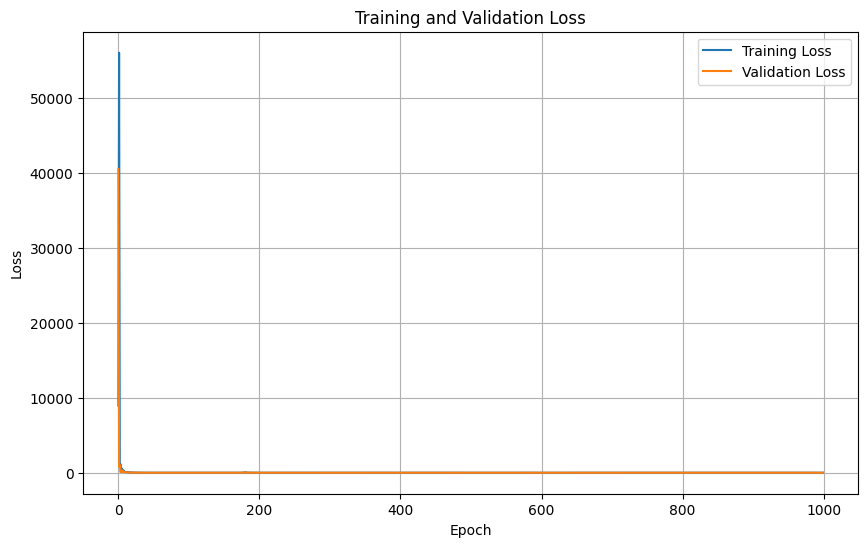

In [30]:
plot_loss(train_loss, valid_loss) # base

In [31]:
final_evaluation(base_gnn_model, test_edge_index, test_edge_weights, user_features, product_features, best_model)

Test loss: 3.0748
Best possible loss: 2.5793


# Do the evaluation 

This will do the recall at K computation  
Did my best to make it as efficient as possible 

In [32]:
def evaluate_recall(model, test_edges, k, batch_size, num_products):
    model.eval()
    all_product_ids = torch.arange(num_products)
    sol = []
    for index in range(0, test_edges.shape[1], batch_size):
        test_user_ids = test_edges[0][index:index+batch_size]
        test_size = test_user_ids.shape[0]
        user_ids_expanded = test_user_ids.unsqueeze(1).expand(-1, num_products)
        product_ids_expanded = all_product_ids.unsqueeze(0).expand(test_size, -1)
        user_ids_flat = user_ids_expanded.reshape(-1)
        product_ids_flat = product_ids_expanded.reshape(-1)
        batch_test_edges = torch.stack([user_ids_flat.cpu(), product_ids_flat]).to(device)
        
        with torch.no_grad():
            scores_flat = base_gnn_model(batch_test_edges, user_features, product_features)
        
        scores = scores_flat.view(test_user_ids.shape[0], num_products)
        topk_scores, topk_indices = torch.topk(scores, k, dim=1)
        true_item_ids = test_edge_index[1][index:index+batch_size]
        recall_hits = (topk_indices == true_item_ids.unsqueeze(1)).any(dim=1).float().cpu().tolist()
        sol.extend(recall_hits)
    
    return torch.tensor(sol).mean()

In [ ]:
# 5 min to to run the full gnn and get results 
evaluate_recall(base_gnn_model, test_edge_index, 10, 32, num_products)
# original is tensor(4.2440e-05)
# reduced is tensor(7.2129e-05)

tensor(0.)

In [34]:
base_gnn_model.load_state_dict(best_model)
evaluate_recall(base_gnn_model, test_edge_index, 10, 32, num_products)

tensor(0.)

In [73]:
# see predictions 
# There is actually changes (small dataset)

user_id = user_features_numeric_agg.user_id.sample(1).item()
print(user_id, "\n")
recomendations, preds = recommend_products(base_gnn_model, user_id, user_id_to_idx, prod_id_to_idx,
                                     user_features, product_features, top_k=10)
pretty_print_recomendations(recomendations, product_features_string, "title")
print("\n")

AFAHR3N6JWZQCT6KPKKQOIWTFTZQ 

Product 1: SWELL SKIN Bare Face Cleansing Bar, 2.25 OZ
Product 2: Tattooed By Inky Koi Stocking Stuffer
Product 3: Makeup Brush Cleaner and Dryer with 2 Optional Speeds, Quickly Wash and Dry Makeup Brushes in Seconds, for All Size Cosmetic Brushes, Professional Makeup Brush Cleaning Solution (Black+Pink)
Product 4: False Eyelashes 4 Pairs - Professional Reusable Face Eyelashes Fit for All Eyes, Natural Thick Hand-Made 3D Faux Mink Eyelashes for a Beautiful Makeup Look G104
Product 5: 2 Pack Nail Soaking Bowl Acrylic Nail Remover Soak Off Tray Polish Remove Wash Soaker Manicure Spa Tool
Product 6: ALICROWN PURPLE Natural Mutipack False Eyelashes 10 Pairs Fake Lashes
Product 7: Adrienne Vittadini Set of 3 Satchel Cosmetic Case (Black & Pink Hex)
Product 8: Gabrielle Essence by Chanel Eau De Parfum Spray 1.7 oz / 50 ml (Women)
Product 9: CXhome Home Facial Steamer Hot and Cold Nano Ionic Mist for Woman Home Spa Facial, Steamer for Face Humidifier for Moistur